# Estimation de la dérivée spatiale $\dfrac{\partial (u,\theta)}{\partial z}$

Ce problème est étudié dans la section 6.2 du rapport.
On compare les résultats des modèles SINDy, KAN et Symbolic KAN sur un segment vertical en $(x,y)=(0.50, 0.25)$ entre $0<z<0.10$.


In [1]:
# import des modules
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
from utils.data_processing import *
from utils.vizualisation import *

import matplotlib.pyplot as plt
import numpy as np
import h5py
from pathlib import Path
import matplotlib.colors as mcolors
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import pysindy as ps
import kan
import torch
import time
from torch import autograd
from tqdm import tqdm

## Préparation des données 

Lecture des données, découpage du segment de données et ajout des conditions limites en $z=0$ : 
$$
\begin{cases}
\left. u \right|_{z=0} = 0 \\ \\
\left. w \right|_{z=0} = 0 \\ \\
\left. \theta \right|_{z=0} = 1
\end{cases}
$$

In [2]:
### parametres des données ###
n_run = 1 # numero de la run de la DNS
slicedir = 2 # direction 2 == y fixé
sliceid = 7 # slice 7 == (y=0.25)
idtime = 6080 # temps initial, ici t0 = 291.49825
ntime = 174 # nombre de points temporels
nfin = int(idtime+ntime-1) # temps final, ici tfin = 295.0015
nech=1 # pas de l'échantillonage 
nlaps = np.arange (idtime,nfin+1,nech) # les instants à récupérer
champs = ['U', 'W', 'T'] # les champs à récupérer
###############################

slices, xx, zz, tt = recup_slices(n_run, slicedir, sliceid, idtime, nlaps, champs)
print('Données récupérées : ')
print(f"    {len(tt):.0f}"+" instantanés entre "+f"{tt[0]:.3f}"+" et "+f" {tt[-1]:.3f}") 
print("    Nombre de point en x : "+f"{len(xx):.0f}")
print("    Nombre de point en z : "+f"{len(zz):.0f}")
print("\n")

### parametres des découpes ###
x_cut = 320 # prend segment au centre (x=0.50 et y=0.25)
z_cut = 125 # prend en hauteur de 0.00 à 0.10
cond_lim = True 
###############################

X = slices[x_cut,:z_cut].astype(np.float32)
t = tt.astype(np.float32)
x = [xx[x_cut].astype(np.float32)]
z = zz[:z_cut].astype(np.float32)
if cond_lim : # conditions limites en z=0 : vitesses nulles et temperature paroi chaude (==1)
    cond_vitesses, cond_temperature = np.zeros((1, len(t), 2)), np.ones((1, len(t), 1))
    assemblage_cond = np.concatenate((cond_vitesses, cond_temperature), axis=2)
    X = np.concatenate((assemblage_cond, X), axis=0) # ajoute sur les données
    z = np.concatenate((np.zeros(1), z)) 
X = np.transpose(X, (1, 0, 2)) # mets les dimensions d'en l'ordre

print('Données découpées : ')
print(f"    {len(t):.0f}"+" instantanés entre "+f"{t[0]:.3f}"+" et "+f" {t[-1]:.3f}") 
print("    Nombre de point en x : "+f"{len(x):.0f}")
print("    Nombre de point en z : "+f"{len(z):.0f}")
print("    Dimensions des données : "+f"{np.shape(X)}")


Données récupérées : 
    174 instantanés entre 291.498 et  295.002
    Nombre de point en x : 640
    Nombre de point en z : 832


Données découpées : 
    174 instantanés entre 291.498 et  295.001
    Nombre de point en x : 1
    Nombre de point en z : 126
    Dimensions des données : (174, 126, 3)


### Création des datasets : 
- SINDy : calcule juste le label $\partial_z$ (à l'initialisation du modèle on choisira la bibliothèque de fonction qu'on normalisera)
- KAN : calcule le label $\partial_z$ et $\partial_t$ à mettre en entrée, puis normalise les entrées

In [3]:
### parametres des datasets ###
normalisation = True # normalise les données d'entrée
test_ratio = 0.3 # test set ratio ==30%
device = 'cpu'
###############################

# créer le label y : les dérivées verticales de u et de theta
y = np.gradient(X[:,:,[0,2]], z, axis=1, edge_order=2)

# calcule la derivée temporelle en entrée pour les KANs
Xt = np.gradient(X, t, axis=0, edge_order=2) 

# créer la matrice d'entrée pour les KANs
X_kan = np.concatenate((X, Xt), axis=2)

# normalisation des données KAN, SINDy le fait dans la bibliothèque
if normalisation : 
    X_kan, mean_X_kan, std_X_kan = normalize(X_kan)

# split train/test 
tscv = TimeSeriesSplit(n_splits=2, test_size=int(t.size*test_ratio))
train_id, test_id = list(tscv.split(t))[1] 

data_kan = {}
data_kan['train_input'] = torch.tensor(X_kan[train_id].reshape(len(z)*len(train_id), X_kan.shape[-1]), dtype=torch.float32, device=device)
data_kan['test_input'] = torch.tensor(X_kan[test_id].reshape(len(z)*len(test_id), X_kan.shape[-1]), dtype=torch.float32, device=device)
data_kan['train_label'] = torch.tensor(y[train_id].reshape(len(z)*len(train_id), y.shape[-1]), dtype=torch.float32, device=device)
data_kan['test_label'] = torch.tensor(y[test_id].reshape(len(z)*len(test_id), y.shape[-1]), dtype=torch.float32, device=device)

# split SINDy
data_sindy = {}
data_sindy['train_input'] = X[train_id]
data_sindy['test_input'] = X[test_id]
data_sindy['train_label'] = y[train_id]
data_sindy['test_label'] = y[test_id]

# to split temporal vector use t[train_id], t[test_id]

print('Datasets prêts : ')
print("    Dimensions pour SINDy | input : "+f"{data_sindy['train_input'].shape}"+ "           | label : "+f"{data_sindy['train_label'].shape}")
print("    Dimensions pour KAN   | input : "+f"{data_kan['train_input'].shape}"+ "  | label : "+f"{data_kan['train_label'].shape}")



Datasets prêts : 
    Dimensions pour SINDy | input : (122, 126, 3)           | label : (122, 126, 2)
    Dimensions pour KAN   | input : torch.Size([15372, 6])  | label : torch.Size([15372, 2])


## SINDy
On passe à la mise en place du modèle SINDy : 
- Définir la librairie de fonction $\Psi$
- L'ajuster aux données $\Psi(u, w, \theta)$
- Entraîner le modèle avec SR3 :
$$\arg\min_{\Xi, W} \dfrac{1}{2}||\dfrac{\partial (u, \theta)}{\partial z}-\Psi(u,w,\theta)\Xi||_2^2 + \lambda ||W|| + \dfrac{\nu}{2} ||\Xi-W||_2^2$$


Les **hyperparamètres** princiaux sont : 
- $\Psi$ le choix de la librairie
- $\lambda$ le coefficient de pénalisation
- $\nu$ le coefficient de relaxation
- le nombre de **pas** d'entraînement



In [4]:
# Constuction des librairies de fonctions
library_functions = [lambda x: x]
library_function_names = [lambda x: x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names, 
    derivative_order=1, 
    spatial_grid=t[train_id], # grille temporelle
    include_bias=True,
    include_interaction=True,
    is_uniform=False,
)

pde_lib_test = ps.PDELibrary( # on fait une librairie test pour ne pas donner les temps de l'ensemble de test
                              # (pour les derivées dt) à la librairie utilisée pour l'entraînement 
    library_functions=library_functions, 
    function_names=library_function_names, 
    derivative_order=1, 
    spatial_grid=t[test_id], # grille temporelle 
    include_bias=True,
    include_interaction=True,
    is_uniform=False,
)

data_sindy['train_transf'] = pde_lib.fit_transform(data_sindy['train_input']) # ajuste Psi aux données d'entraînement
data_sindy['test_transf'] = pde_lib_test.fit_transform(data_sindy['test_input']) # ajuste Psi aux données de test
feature_name = pde_lib.get_feature_names(input_features=champs) 
print('Construction de la librairie de fonctions :')
print("    Nombre de fonctions : "+f"{len(feature_name)}")
print("    Exemples de fonctions : "+f"{[term.replace('_1', '_t') for term in np.random.choice(feature_name, 3, replace=False)]}")

Construction de la librairie de fonctions :
    Nombre de fonctions : 16
    Exemples de fonctions : ['UU_t', 'WU_t', 'WW_t']


In [5]:
# Entrainement avec SR3
n_iters = 30 # pas d'entrainement
opt_sindy = ps.SR3(
    threshold=10, # lambda 
    thresholder='l1', 
    normalize_columns=normalisation, # on normalise les données d'entrée Psi(u, w, theta)
    max_iter=n_iters, 
    verbose=False, 
    tol=1e-5, 
    nu=.5, # nu
)
model_sindy = ps.SINDy(
    feature_library=pde_lib, 
    optimizer=opt_sindy, 
    feature_names=champs,
)

model_sindy.fit(data_sindy['train_input'], x_dot=data_sindy['train_label'], quiet=True);

# calcule des métriques à l'aide de l'historique des coefficients Xi
metrics_sindy = {}
metrics_sindy['mae_train'], metrics_sindy['mae_test'] = [], [] # mean absolute error
metrics_sindy['mse_train'], metrics_sindy['mse_test'] = [], [] # mean squared error
metrics_sindy['complexity'] = [] # complexity == number of nonzero coefficients
for coef in model_sindy.optimizer.history_ : # calcule l'historique des scores
    metrics_sindy['complexity'].append(np.count_nonzero(coef))
    pred_train = (data_sindy['train_transf'] @ coef.T)
    pred_test = (data_sindy['test_transf'] @ coef.T)
    metrics_sindy['mae_train'].append(np.mean(np.abs(pred_train - data_sindy['train_label'])))
    metrics_sindy['mae_test'].append(np.mean(np.abs(pred_test - data_sindy['test_label'])))
    metrics_sindy['mse_train'].append(np.mean((pred_train - data_sindy['train_label'])**2))
    metrics_sindy['mse_test'].append(np.mean((pred_test - data_sindy['test_label'])**2))

# mean total of squares to compute the r2 score (here mtss for each derivative field)
mtss_train = np.mean((data_sindy['train_label'] - data_sindy['train_label'].mean(axis=(0, 1)))**2, axis=(0, 1))
mtss_test = np.mean((data_sindy['test_label'] - data_sindy['test_label'].mean(axis=(0, 1)))**2, axis=(0, 1))
# r2 score
metrics_sindy['r2_train'] = 1 - metrics_sindy['mse_train'] / mtss_train.mean()
metrics_sindy['r2_test'] = 1 - metrics_sindy['mse_test'] / mtss_test.mean()
# BIC 
n = model_sindy.optimizer.Theta_.shape[0]
metrics_sindy['bic_test'] = n * np.log(np.array(metrics_sindy['mse_test'])) + np.log(n) * np.array(metrics_sindy['complexity'])

Maintenant, on observe les performances du modèle en regardant les métriques comme le MSE, RMSE, MAE, $\text{R}^2$ et la complexité.


Pour faire une optimisation précise des hyperparamètre on peut utiliser des scores qui pénalise la complexité comme l'AIC et le BIC (plus bas, un exemple du BIC pour le choix du pas d'entraînement). 


On regarde aussi les prédictions sur le champs $(t, z)$ pour voir comment se comporte le modèle et où sont localisées les erreurs.
Niveau interprétation la complexité donne une idée mais on peut aussi extraire des équations symboliques que voici : 

In [6]:
print(r"Modèle SINDy-PDE avec SR3:")
print("     Nombre de coefficients d'apprentissage :", model_sindy.coefficients().shape)
print("     Complexité du modèle : "+f"{metrics_sindy['complexity'][-1]:.0f}")
print("     MSE score  | training : "+f"{metrics_sindy['mse_train'][-1]:.3f}", "| testing : "+f"{metrics_sindy['mse_test'][-1]:.3f}") # mse
print("     RMSE score | training :  "+f"{np.sqrt(metrics_sindy['mse_train'][-1]):.3f}", "| testing :  "+f"{np.sqrt(metrics_sindy['mse_test'][-1]):.3f}") # rmse
print("     MAE score  | training :  "+f"{metrics_sindy['mae_train'][-1]:.3f}", "| testing :  "+f"{metrics_sindy['mae_test'][-1]:.3f}") # mae
print("     R2 score   | training :  "+f"{metrics_sindy['r2_train'][-1]:.3f}", "| testing :  "+f"{metrics_sindy['r2_test'][-1]:.3f}") # r2 
print('\nEquations symboliques :')
model_sindy.print(lhs=['dU/dz','dT/dz'], precision=2)

Modèle SINDy-PDE avec SR3:
     Nombre de coefficients d'apprentissage : (2, 16)
     Complexité du modèle : 24
     MSE score  | training : 55.447 | testing : 70.284
     RMSE score | training :  7.446 | testing :  8.384
     MAE score  | training :  4.157 | testing :  5.018
     R2 score   | training :  0.756 | testing :  0.733

Equations symboliques :
dU/dz = -19.94 1 + -10.43 W + 39.74 T + -23.00 U_1 + -29.21 W_1 + 15.52 T_1 + 27.87 UW_1 + 48.55 UT_1 + -18.34 WU_1 + -5.64 WW_1 + 67.57 WT_1 + -29.39 TT_1
dT/dz = 82.28 1 + 16.12 U + -176.07 T + -87.02 U_1 + -28.75 T_1 + 178.55 UT_1 + -26.01 WU_1 + 9.33 WW_1 + 11.81 WT_1 + 68.27 TU_1 + -50.57 TW_1 + 40.10 TT_1


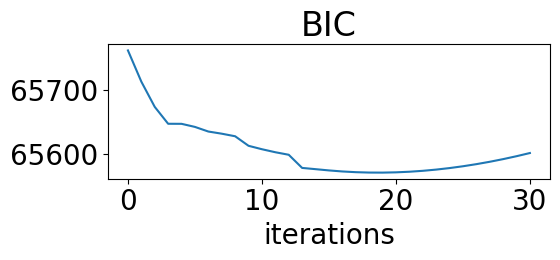

In [7]:
# plot le bic (minimisation du bic vers les 15-20 iterations)
plt.figure(figsize=(6,3))
plt.plot(metrics_sindy['bic_test'])
plt.title("BIC")
plt.xlabel("iterations")
plt.tight_layout()
plt.show()

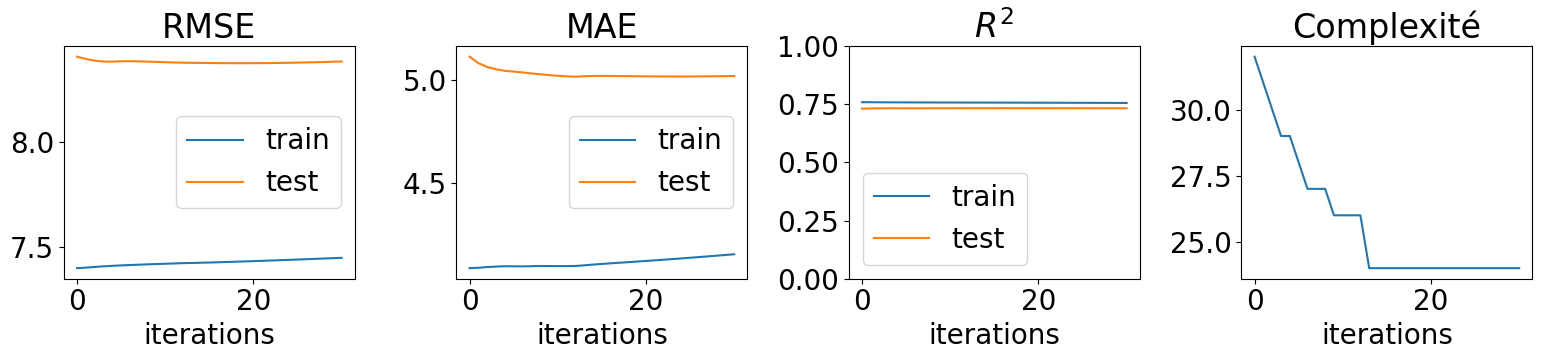

In [8]:
plot_metrics(metrics_sindy)

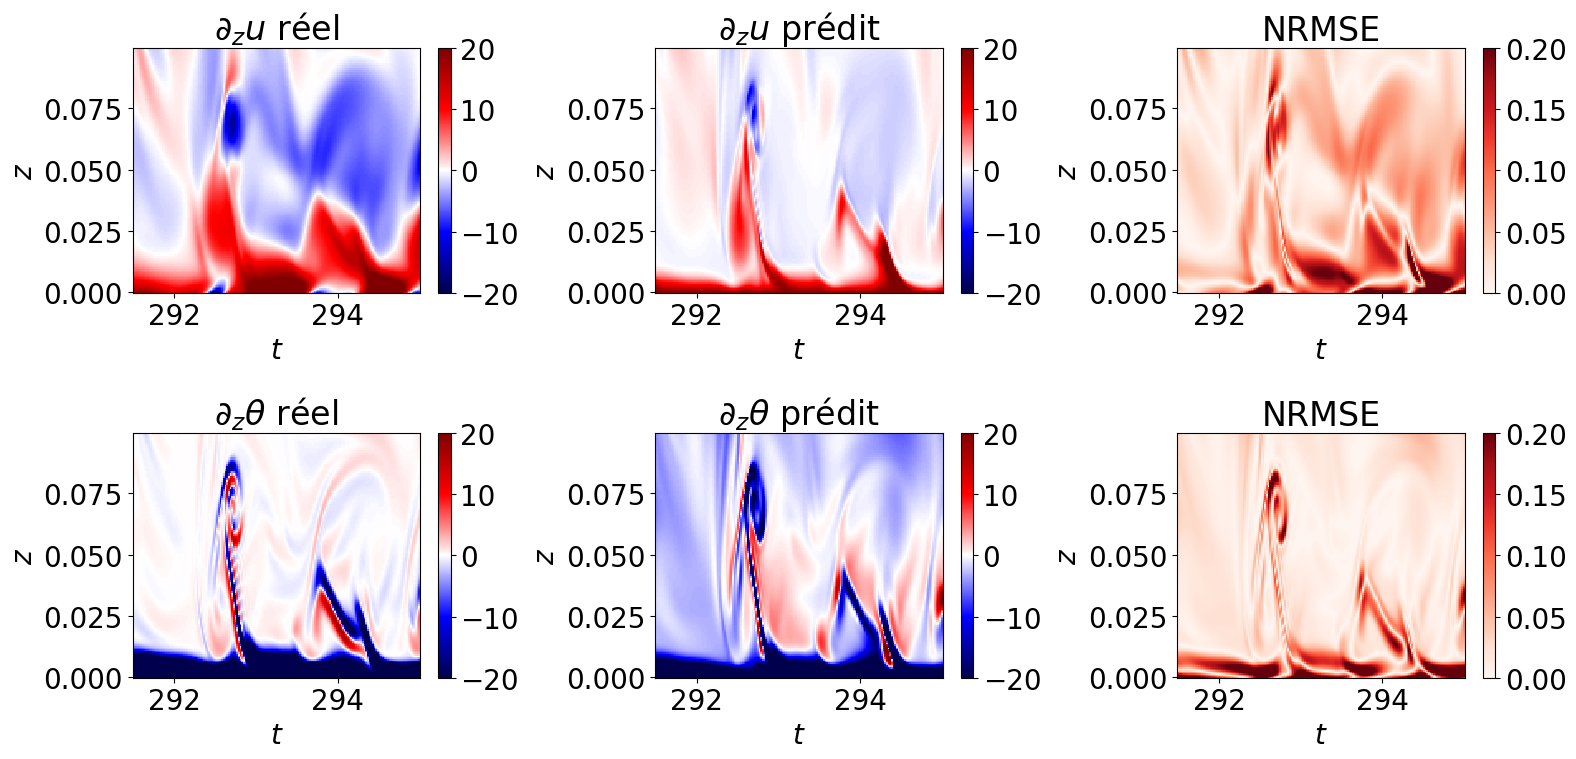

In [9]:
data_concat = np.concatenate([data_sindy['train_transf'], data_sindy['test_transf']], axis=0)
pred_concat = data_concat @ model_sindy.coefficients().T
plot_results(t, z, y, pred_concat)

Comme le modèle SINDy est initialisé avec une régression non régularisée complète, les score de performances sont de suite très haut et l'objectif est de conserver le plus de possible de précision durant la régularisation parcimonieuse (qui vient faire perdre en complexité en mettant des coefficients à zéro). 

Sur l'exemple de BIC on voit que vers 15-20 itérations on atteint un pas optimal pour les autres hyperparamètres choisis.

Enfin au niveau des prédictions, on remarque que le modèle SINDy retrouve plutôt bien la structure mais les erreurs sont concentrées proche de la paroi (zone d'intérêt).

In [10]:
# testez d'autres hyperparamètres ici 

# KAN

On passe à la mise en place du modèle KAN : 
- initialiser le modèle : choix architecture et coefficient de régularisation
- entraîner le modèle avec L-BFGS (en full-batch) avec mise à jour de la grille de splines
- élaguer le modèle selon le score d'attribution (voir rapport ou [3])
- entraîner encore

=> on a un **modèle KAN élagué**

Les **hyperparamètres** princiaux sont : 
- l'architecture du modèle (couches, neurones)
- la fonction de coût et sa pénalisation
- les pas d'entraînements
- le seuil d'élagage

In [11]:
in_vars=['$u$', '$w$', r'$\theta$', 
        r'$\frac{\partial u}{\partial t}$', 
        r'$\frac{\partial w}{\partial t}$', 
        r'$\frac{\partial \theta}{\partial t}$',  ]
out_vars=[r'$\frac{\partial u}{\partial z}$', 
        r'$\frac{\partial \theta}{\partial z}$']

model_kan = kan.KAN( # initialise le modele
    width=[data_kan['train_input'].shape[-1], [3, 2], data_kan['train_label'].shape[-1]],
    grid=3, k=3, seed=1501, sparse_init=False,
)

kan_compl = [] 
steps_list = [6, 24] # les pas d'entrainement
torch.nn.functional.l1_loss.__name__='mae' # change les noms des metrics à calculer
torch.nn.functional.mse_loss.__name__='mse'

loss1 = model_kan.fit( # premier entrainement
    data_kan, 
    steps=steps_list[0], 
    loss_fn=torch.nn.MSELoss(), # fonction de coût
    update_grid = True, # met à jour la grille spline
    grid_update_num=3, # la met à jour après 3 pas
    lr = 5e-1, # learning rate
    lamb=10, # pénalisation
    opt='LBFGS', # optimiseur
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], # calcule la loss pour le MSE et le MAE
    log=1,
);
kan_compl.append( model_kan.n_edge )

model_kan.prune(0.3) # elagage

loss2 = model_kan.fit( # second entrainement
    data_kan, 
    steps=steps_list[1], 
    loss_fn=torch.nn.MSELoss(), # fonction de coût
    update_grid = False, # ne met pas à jour la grille spline
    lr = 5e-1, # learning rate
    lamb=0.1, # pénalisation
    opt='LBFGS', # optimiseur
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], # calcule la loss pour le MSE et le MAE
    log=1,
);
kan_compl.append( model_kan.n_edge )

metrics_kan = {}
for k in loss1.keys():
    metrics_kan[k] = loss1[k] + loss2[k]
metrics_kan['r2_train'] = 1 - metrics_kan['mse_train'] / mtss_train.mean()
metrics_kan['r2_test'] = 1 - metrics_kan['mse_test'] / mtss_test.mean()
metrics_kan['complexity'] = list(np.concatenate([np.ones(steps_list[0])*kan_compl[0],np.ones(steps_list[1])*kan_compl[1]]))


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.58e+01 | test_loss: 1.69e+01 | reg: 6.52e-01 | : 100%|█| 6/6 [00:10<00:00,  1.72s/it


saving model version 0.1
saving model version 0.2


| train_loss: 5.32e+00 | test_loss: 9.69e+00 | reg: 1.96e+01 | : 100%|█| 24/24 [00:39<00:00,  1.66s/

saving model version 0.2


Modèle KAN pruned avec LBFGS:
     Nombre de branche à l'initialisation : 52.0
     Nombre de branche après l'entraînement : 8.0
     MSE score  | training : 28.263 | testing : 93.855
     RMSE score | training :  5.316 | testing :  9.688
     MAE score  | training :  2.939 | testing :  5.377
     R2 score   | training :  0.875 | testing :  0.643




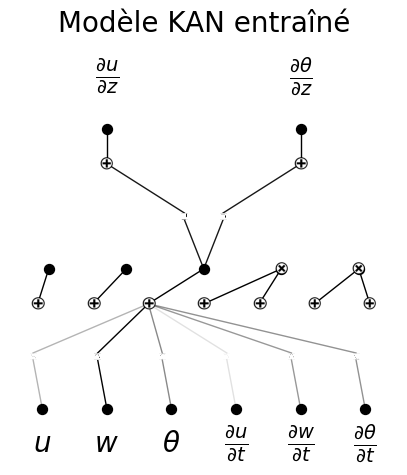

In [12]:

print(r"Modèle KAN pruned avec LBFGS:")
print("     Nombre de branche à l'initialisation :", metrics_kan['complexity'][0])
print("     Nombre de branche après l'entraînement :", metrics_kan['complexity'][-1])
print("     MSE score  | training : "+f"{metrics_kan['mse_train'][-1]:.3f}", "| testing : "+f"{metrics_kan['mse_test'][-1]:.3f}") # mse
print("     RMSE score | training :  "+f"{np.sqrt(metrics_kan['mse_train'][-1]):.3f}", "| testing :  "+f"{np.sqrt(metrics_kan['mse_test'][-1]):.3f}") # rmse    
print("     MAE score  | training :  "+f"{metrics_kan['mae_train'][-1]:.3f}", "| testing :  "+f"{metrics_kan['mae_test'][-1]:.3f}") # mae
print("     R2 score   | training :  "+f"{metrics_kan['r2_train'][-1]:.3f}", "| testing :  "+f"{metrics_kan['r2_test'][-1]:.3f}") # r2 
print('\n')

model_kan.plot(in_vars=in_vars, out_vars=out_vars, title="Modèle KAN entraîné")


Maintenant, on observe les performances du modèle en regardant les métriques comme le MSE, RMSE, MAE, $\text{R}^2$ et la complexité.

On regarde aussi les prédictions sur le champs $(t, z)$ pour voir comment se comporte le modèle et où sont localisées les erreurs.
Niveau interprétation la complexité est ici le nombre de branches actives, cela donne une idée mais le modèle ne permet pas d'extraire des équations symboliques.

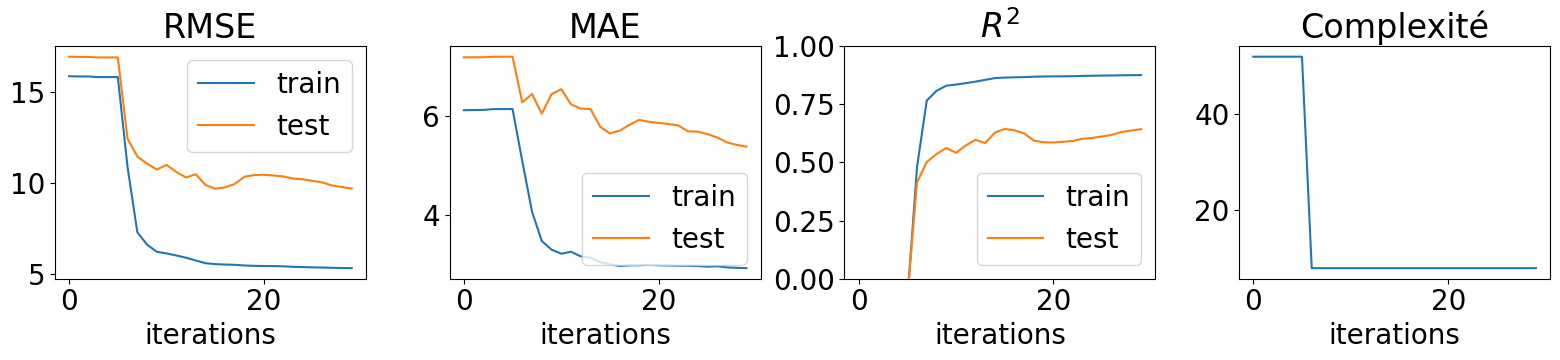

In [13]:
plot_metrics(metrics_kan)

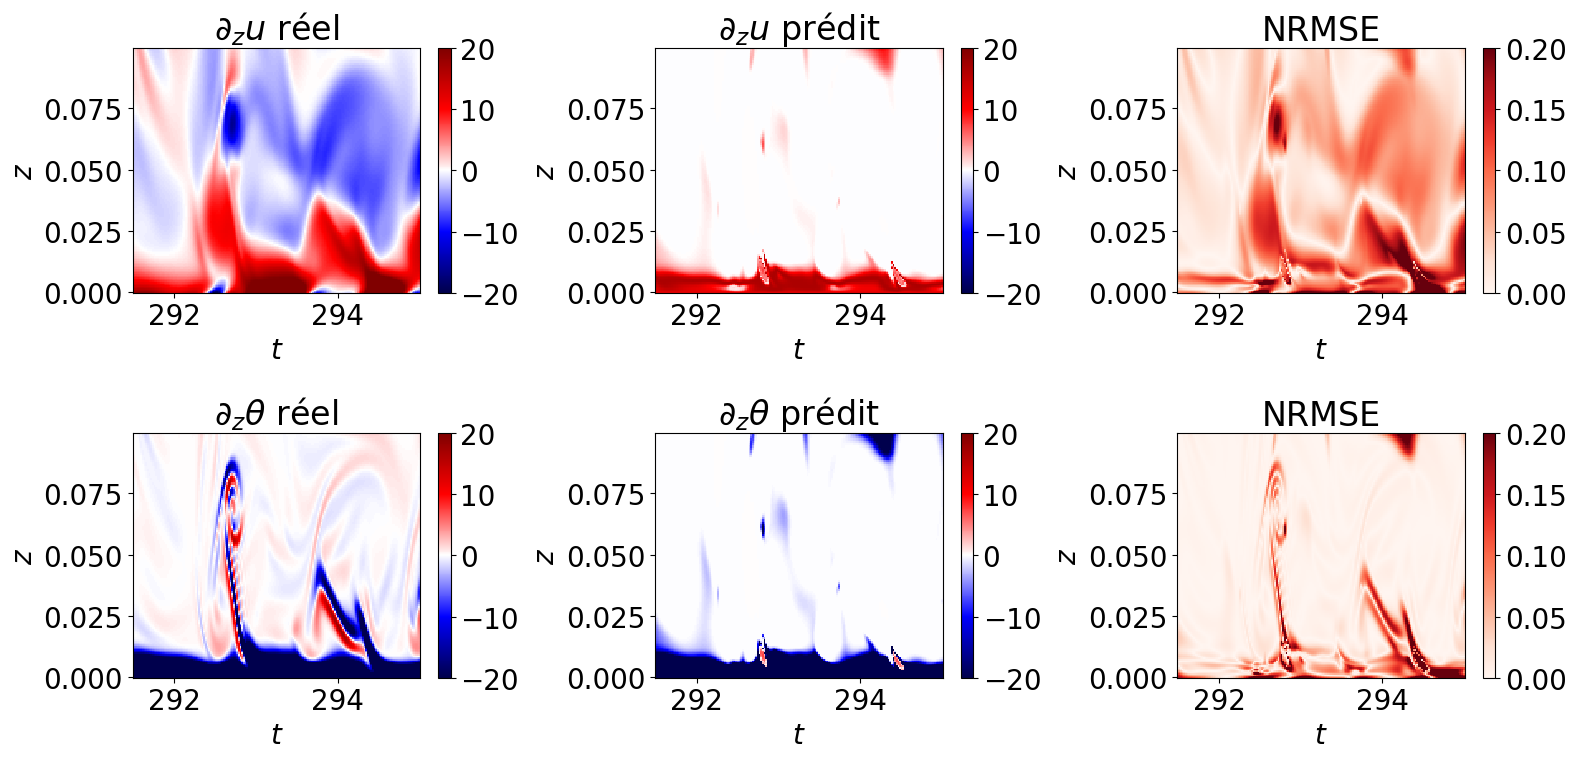

In [14]:
data_concat = torch.concatenate([data_kan['train_input'], data_kan['test_input']], axis=0)
pred_concat = model_kan(data_concat).reshape(len(t), len(z), -1).detach().numpy()
plot_results(t, z, y, pred_concat)

On observe une nette amélioration des performances après l'élagage, c'est dû à une régularisation très forte avant qui permet de passer à un modèle très simple à partir de l'élagage. L'entraînement post-élagage est lui moins régularisé et met en priorité la minimisation de la fonction de coût.

Enfin au niveau des prédictions, on remarque que le modèle KAN retrouve moins la structure et se concentre davantage sur la partie proche paroi, sur laquelle il fait moins d'erreur que SINDy. Mais les erreurs sont toujours majoritairement proche de la paroi (zone d'intérêt).

In [15]:
# testez d'autres hyperparamètres ici 

## Symbolic KAN

Comme l'élagage précédent permet d'obtenir un modèle KAN avec une structure simple, composé d'un unique noeud caché, on va maintenant partir de cette architecture afin de passer à un modèle symbolique. Les étapes pour la mise en place de ce modèle : 
- initialiser le modèle selon l'architecture finale de KAN précédent
- entraîner le modèle avec L-BFGS (en full-batch) avec mise à jour de la grille de splines
- convertir les splines en fonctions symboliques, si le score du $R^2>\rho$
- entraîner encore
- convertir les splines restantes en fonctions symboliques
- entraîner à nouveau

=> on a un **modèle KAN symbolique**

Les **hyperparamètres** princiaux sont :
- les pas d'entraînements
- les fonctions symboliques disponibles à la conversion
- le seuil de conversion $\rho$

In [57]:
model_skan = kan.KAN( # initialise le modele
    width=[data_kan['train_input'].shape[-1], [1, 0], data_kan['train_label'].shape[-1]],
    grid=3, k=3, seed=1501, sparse_init=False,
)

np.random.seed(1501)
kan_compl = [] 
steps_list = [6, 12, 12] # les pas d'entrainement
torch.nn.functional.l1_loss.__name__='mae' # change les noms des metrics à calculer
torch.nn.functional.mse_loss.__name__='mse'

loss1 = model_skan.fit( # premier entrainement
    data_kan, 
    batch=-1,
    steps=steps_list[0], 
    loss_fn=torch.nn.MSELoss(), # fonction de coût
    update_grid = True, # met à jour la grille spline
    grid_update_num=3, # la met à jour après 3 pas
    lr = 5e-1, # learning rate
    lamb=1, # pénalisation
    opt='LBFGS', # optimiseur
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], # calcule la loss pour le MSE et le MAE
    log=1,
);
kan_compl.append( model_kan.n_edge )

# deux façons de faire : 
# l'auto symbolique puis unfix les fonctions avec le R2 sous un certain seuil
# model_skan.auto_symbolic(lib=['x', '1/x', 'x^2', 'exp', 'log']) # peut modifier les fonctions pour le passage en symbolique

# on peut choisir spécifiquement par quelle fonction remplacer la spline :
# model_skan.fix_symbolic(0, 0, 0, 'x')


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.29e+00 | test_loss: 9.95e+00 | reg: 1.83e+01 | : 100%|█| 6/6 [00:04<00:00,  1.43it/s

saving model version 0.1


In [58]:
# unfix if R2<0.50
# model_skan.unfix_symbolic(1,0,0)

loss2 = model_kan.fit( # second entrainement
    data_kan, 
    batch=-1,
    steps=steps_list[1], 
    loss_fn=torch.nn.MSELoss(), # fonction de coût
    update_grid = False, # ne met pas à jour la grille spline
    lr = 5e-1, # learning rate
    lamb=.1, # pénalisation
    opt='LBFGS', # optimiseur
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], # calcule la loss pour le MSE et le MAE
    log=1,
);

kan_compl.append( model_skan.n_edge )
#model_skan.fix_symbolic(0, 4, 0, 'x^2');
#model_skan.fix_symbolic(0, 2, 0, 'exp');
#model_skan.fix_symbolic(1, 0, 1, 'exp');
#model_skan.auto_symbolic(lib=['x']);
model_skan.auto_symbolic(lib=['x', '1/x', 'x^2', 'exp', 'log']); # peut modifier les fonctions pour le passage en symbolique


| train_loss: 5.21e+00 | test_loss: 9.22e+00 | reg: 1.97e+01 | : 100%|█| 12/12 [00:04<00:00,  2.61it


saving model version 0.16
fixing (0,0,0) with x, r2=0.7140832543373108, c=1
fixing (0,1,0) with x^2, r2=0.9894970059394836, c=2
fixing (0,2,0) with x, r2=0.73088139295578, c=1
fixing (0,3,0) with x, r2=0.8730109930038452, c=1
fixing (0,4,0) with x^2, r2=0.981962263584137, c=2
fixing (0,5,0) with x, r2=0.8903940916061401, c=1
fixing (1,0,0) with x, r2=0.46089717745780945, c=1
fixing (1,0,1) with exp, r2=0.9711933732032776, c=2
saving model version 0.2


In [59]:

loss3 = model_kan.fit( # second entrainement
    data_kan, 
    batch=-1,
    steps=steps_list[2], 
    loss_fn=torch.nn.MSELoss(), # fonction de coût
    update_grid = False, # ne met pas à jour la grille spline
    lr = 5e-1, # learning rate
    lamb=0.1, # pénalisation
    opt='LBFGS', # optimiseur
    metrics=[torch.nn.functional.mse_loss, torch.nn.functional.l1_loss], # calcule la loss pour le MSE et le MAE
    log=1,
);

kan_compl.append( model_skan.n_edge )

metrics_skan = {}
for k in loss1.keys():
    metrics_skan[k] = loss1[k] + loss2[k] + loss3[k]
metrics_skan['r2_train'] = 1 - metrics_skan['mse_train'] / mtss_train.mean()
metrics_skan['r2_test'] = 1 - metrics_skan['mse_test'] / mtss_test.mean()
metrics_skan['complexity'] = list(np.concatenate([np.ones(steps_list[0])*kan_compl[0],np.ones(steps_list[1])*kan_compl[1],np.ones(steps_list[2])*kan_compl[2]]))

| train_loss: 5.21e+00 | test_loss: 9.22e+00 | reg: 1.97e+01 | : 100%|█| 12/12 [00:15<00:00,  1.29s/

saving model version 0.17


Modèle KAN symbolique avec L-BFGS:
     Nombre de branche à l'initialisation : 8.0
     Nombre de branche après l'entraînement : 0.0
     MSE score  | training : 27.161 | testing : 84.983
     RMSE score | training :  5.212 | testing :  9.219
     MAE score  | training :  2.877 | testing :  5.116
     R2 score   | training :  0.880 | testing :  0.677




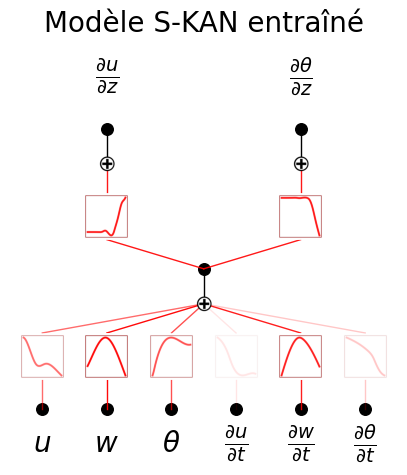

In [60]:

print(r"Modèle KAN symbolique avec L-BFGS:")
print("     Nombre de branche à l'initialisation :", metrics_skan['complexity'][0])
print("     Nombre de branche après l'entraînement :", metrics_skan['complexity'][-1])
print("     MSE score  | training : "+f"{metrics_skan['mse_train'][-1]:.3f}", "| testing : "+f"{metrics_skan['mse_test'][-1]:.3f}") # mse
print("     RMSE score | training :  "+f"{np.sqrt(metrics_skan['mse_train'][-1]):.3f}", "| testing :  "+f"{np.sqrt(metrics_skan['mse_test'][-1]):.3f}") # rmse    
print("     MAE score  | training :  "+f"{metrics_skan['mae_train'][-1]:.3f}", "| testing :  "+f"{metrics_skan['mae_test'][-1]:.3f}") # mae
print("     R2 score   | training :  "+f"{metrics_skan['r2_train'][-1]:.3f}", "| testing :  "+f"{metrics_skan['r2_test'][-1]:.3f}") # r2 
print('\n')

model_skan.plot(in_vars=in_vars, out_vars=out_vars, title="Modèle S-KAN entraîné")


Maintenant, on observe les performances du modèle en regardant les métriques comme le MSE, RMSE, MAE, $\text{R}^2$ et la complexité.

On regarde aussi les prédictions sur le champs $(t, z)$ pour voir comment se comporte le modèle et où sont localisées les erreurs.
Niveau interprétation la complexité est ici le nombre de branches splines actives, comme on passe à des splines symboliques ça tombe à zéro, mais cette fois-ci on extrait des équations symboliques.

In [61]:
print("du/dz =",kan.ex_round(model_skan.symbolic_formula()[0][0], 2))
print("dT/dz =",kan.ex_round(model_skan.symbolic_formula()[0][1], 2))

du/dz = -0.43*x_1 + 0.6*x_3 - 0.1*x_4 - 0.16*x_6 - 1.64*(0.13 - x_2)**2 - 1.76*(-x_5 - 0.04)**2 + 3.91
dT/dz = 2.17 - 12.14*exp(-0.3*x_1 + 0.41*x_3 - 0.07*x_4 - 0.11*x_6 - 1.13*(0.13 - x_2)**2 - 1.22*(-x_5 - 0.04)**2)


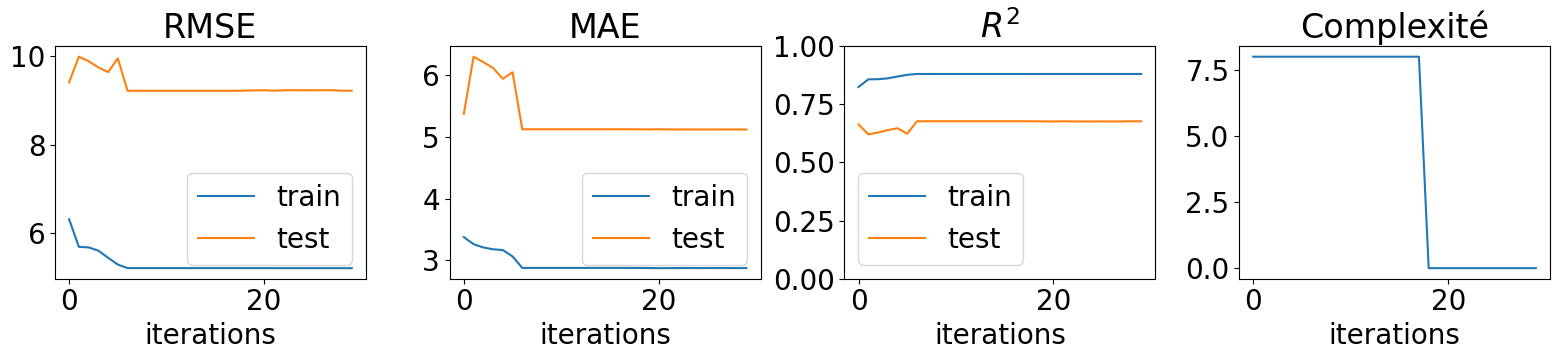

In [62]:
plot_metrics(metrics_skan)

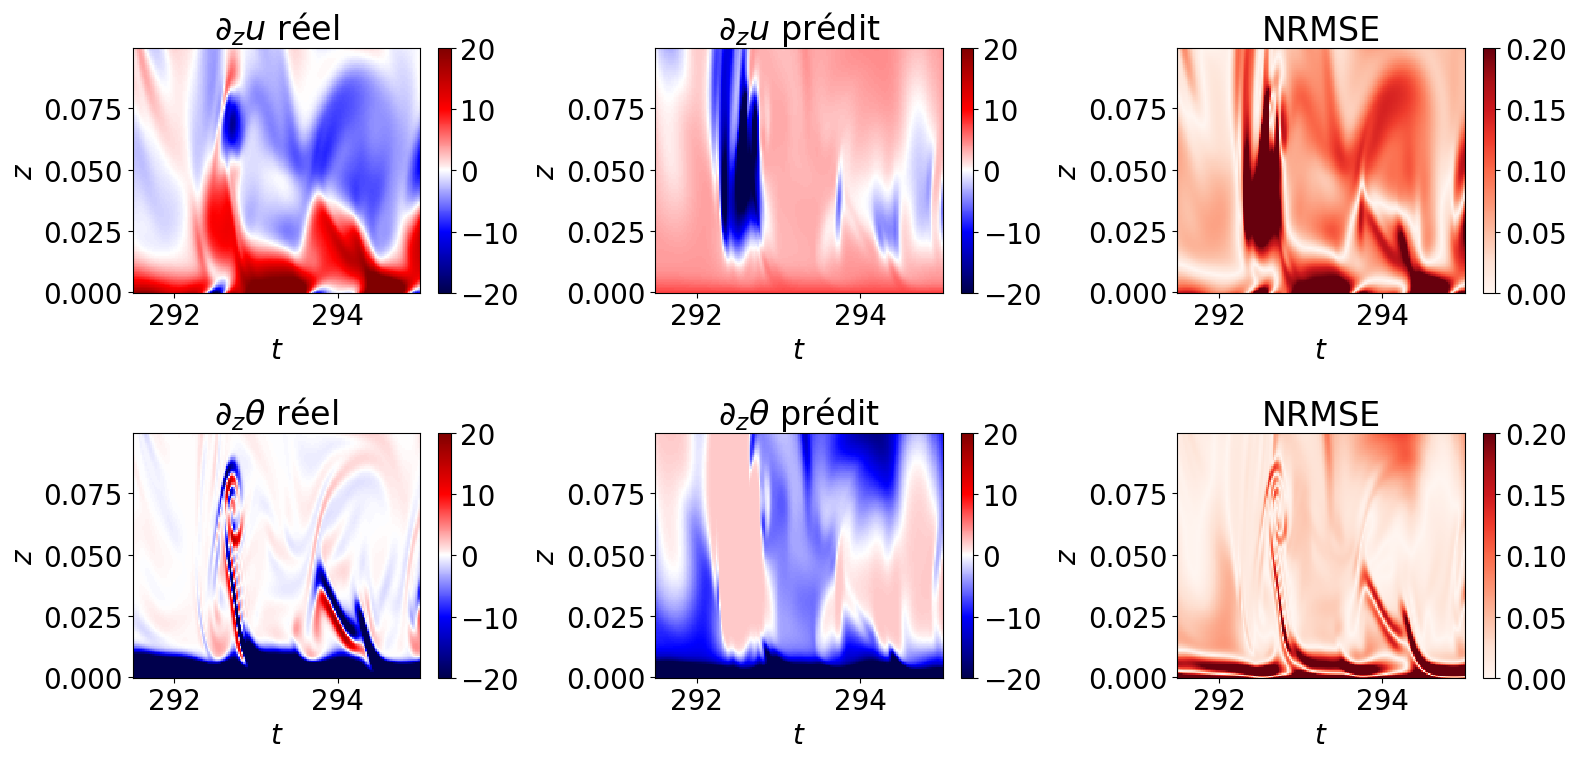

In [63]:
data_concat = torch.concatenate([data_kan['train_input'], data_kan['test_input']], axis=0)
pred_concat = model_skan(data_concat).reshape(len(t), len(z), -1).detach().numpy()
plot_results(t, z, y, pred_concat)

In [23]:
# testez d'autres hyperparamètres ici 

## Synthèse des résultats

Les performances des trois modèles sont proches. Des améliorations restent possibles avec une optimisation complète des modèles.

Globalement, les erreurs se concentrent dans la partie proche de la paroi appelée **couche visqueuse** (ici $z<0.01$). Dans cette région le régime d'écoulement est différent et les gradients sont bien plus importants. Ce qui explique que les erreurs sont plus fréquentes et que le modèle KAN élagué essaie se concentre dessus et reproduit moins la structure des gradients en dehors de cette zone.

Pour la suite de l'étude, on entraînera des modèles experts de cette couche visqueuse, voir le notebook couche_visqueuse.ipynb.

Quelques idées d'optimsation : 
- optimisation dur avec BIC pour sindy sur les pas, $\lambda$ et $\nu$
- moins de pénalisation sur le premier entraînement du KAN quitte à augmenter le seuil d'élagage
- utiliser l'idée de seuillage $\rho$ et bien l'ajuster pour les S-KANs